## Part 1.1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from PIL import Image

### Read Data

In [ ]:
# Load the dataset
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

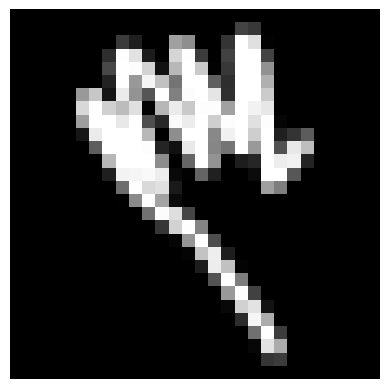

In [ ]:
# random_image = np.random.randint(0, train_images.shape[0], size=1)[0]
# Image.fromarray(train_images[random_image]).show()
# Doesn't work in colab I think.
random_image = np.random.randint(0, train_images.shape[0], size=1)[0]
# Display the image using matplotlib
plt.imshow(train_images[random_image], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print(train_images.shape) # (20000, 28, 28)
print(train_labels.shape) # (20000,)
print(test_images.shape) # (5000, 28, 28)
print(test_labels.shape) # (5000,)

(20000, 28, 28)
(20000,)
(5000, 28, 28)
(5000,)


In [ ]:
# Normalize and flatten images
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

In [ ]:
print(train_images.shape) # (20000, 28, 28)
print(train_labels.shape) # (20000,)
print(test_images.shape) # (5000, 28, 28)
print(test_labels.shape) # (5000,)

(20000, 784)
(20000,)
(5000, 784)
(5000,)


In [ ]:
train_labels

array([1, 3, 3, ..., 2, 3, 2])

### Functions

In [ ]:
# One-hot encode labels
def one_hot_encode(labels, num_classes=5):
    return np.eye(num_classes)[labels]

train_labels_onehot = one_hot_encode(train_labels)
test_labels_onehot = one_hot_encode(test_labels)

In [ ]:
# Initialize network parameters
def initialize_weights(input_dim, hidden_dim, output_dim):
    weights = {
        "W1": np.random.randn(input_dim, hidden_dim) * 0.01,  # Gaussian Initialization
        "b1": np.zeros((1, hidden_dim)),
        "W2": np.random.randn(hidden_dim, output_dim) * 0.01,
        "b2": np.zeros((1, output_dim))
    }
    return weights

In [ ]:
# Data Loader
def batch_generator(X, y, batch_size=64):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0], batch_size):
        end_idx = min(start_idx + batch_size, X.shape[0])
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

In [ ]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

def softmax(x):  # https://cs231n.github.io/linear-classify/#softmax
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


https://stackoverflow.com/a/40756996
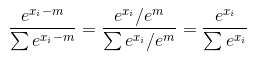

In [ ]:
# Forward pass
def forward_pass(X, weights):
    Z1 = np.dot(X, weights["W1"]) + weights["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, weights["W2"]) + weights["b2"]
    A2 = softmax(Z2)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

In [ ]:
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

In [ ]:
# Backpropagation
def backpropagate(X, y_true, weights, cache, learning_rate=0.01, momentum=0.9, velocity=None):
    m = X.shape[0]
    dZ2 = cache["A2"] - y_true
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * (cache["Z1"] > 0)  # ReLU derivative
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Momentum update
    if velocity is None:
        velocity = {"dW1": np.zeros_like(dW1), "db1": np.zeros_like(db1), "dW2": np.zeros_like(dW2), "db2": np.zeros_like(db2)}

    velocity["dW1"] = momentum * velocity["dW1"] - learning_rate * dW1
    velocity["db1"] = momentum * velocity["db1"] - learning_rate * db1
    velocity["dW2"] = momentum * velocity["dW2"] - learning_rate * dW2
    velocity["db2"] = momentum * velocity["db2"] - learning_rate * db2

    weights["W1"] += velocity["dW1"]
    weights["b1"] += velocity["db1"]
    weights["W2"] += velocity["dW2"]
    weights["b2"] += velocity["db2"]

    return weights, velocity

In [ ]:
def train_mlp(X_train, y_train, X_val, y_val, hidden_dim=128, epochs=50, batch_size=64, learning_rate=0.01, patience=5):
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    weights = initialize_weights(input_dim, hidden_dim, output_dim)
    velocity = None

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
            A2, cache = forward_pass(X_batch, weights)
            loss = cross_entropy_loss(y_batch, A2)
            weights, velocity = backpropagate(X_batch, y_batch, weights, cache, learning_rate, velocity=velocity)
            epoch_loss += loss

        A2_val, _ = forward_pass(X_val, weights)
        val_loss = cross_entropy_loss(y_val, A2_val)
        avg_train_loss = epoch_loss / (X_train.shape[0] // batch_size)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = weights.copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    return best_weights, train_losses, val_losses

In [ ]:
# Evaluate model
def evaluate_model(X_test, y_test, weights):
    A2, _ = forward_pass(X_test, weights)
    predictions = np.argmax(A2, axis=1)
    true_labels = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    roc_auc = roc_auc_score(y_test, A2, multi_class='ovr')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    return accuracy, precision, recall, f1, roc_auc

### Gradient test (I have a function below in Part 1.2)

In [ ]:
# Get first mini-batch
X_batch, y_batch = next(iter(train_loader))
X_np = X_batch.numpy()
y_np = y_batch.numpy()
y_onehot = np.eye(5)[y_np]

In [ ]:
# Forward pass (scratch)
scratch_weights = initialize_weights(784, 256, 5)
A2, cache = forward_pass(X_np, scratch_weights)
loss_scratch = cross_entropy_loss(y_onehot, A2)

# Backpropagation (scratch)
scratch_weights, scratch_velocity = backpropagate(X_np, y_onehot, scratch_weights, cache, learning_rate=0.01, momentum=0.0)

# Save gradients
dW1_scratch = scratch_velocity["dW1"] / -0.01  # remove lr effect


In [ ]:
with torch.no_grad():
    model.fc1.weight.copy_(torch.tensor(scratch_weights["W1"].T))
    model.fc1.bias.copy_(torch.tensor(scratch_weights["b1"].flatten()))
    model.fc2.weight.copy_(torch.tensor(scratch_weights["W2"].T))
    model.fc2.bias.copy_(torch.tensor(scratch_weights["b2"].flatten()))


In [ ]:
model.train()
optimizer.zero_grad()
outputs = model(X_batch)
loss_torch = criterion(outputs, y_batch)
loss_torch.backward()


In [ ]:
grad_torch = model.fc1.weight.grad.detach().numpy().T  # shape match

diff = np.abs(dW1_scratch - grad_torch)
print("Mean absolute difference in W1 gradients:", np.mean(diff))


Mean absolute difference in W1 gradients: 0.00021118422245272408


### Training

Epoch 1/50 - Train Loss: 0.9846 - Val Loss: 0.6910
Epoch 2/50 - Train Loss: 0.6613 - Val Loss: 0.6435
Epoch 3/50 - Train Loss: 0.6096 - Val Loss: 0.6113
Epoch 4/50 - Train Loss: 0.5613 - Val Loss: 0.5797
Epoch 5/50 - Train Loss: 0.5199 - Val Loss: 0.5599
Epoch 6/50 - Train Loss: 0.4828 - Val Loss: 0.5360
Epoch 7/50 - Train Loss: 0.4509 - Val Loss: 0.5170
Epoch 8/50 - Train Loss: 0.4198 - Val Loss: 0.5199
Epoch 9/50 - Train Loss: 0.3909 - Val Loss: 0.4993
Epoch 10/50 - Train Loss: 0.3662 - Val Loss: 0.4950
Epoch 11/50 - Train Loss: 0.3395 - Val Loss: 0.4886
Epoch 12/50 - Train Loss: 0.3164 - Val Loss: 0.4947
Epoch 13/50 - Train Loss: 0.2958 - Val Loss: 0.4915
Epoch 14/50 - Train Loss: 0.2725 - Val Loss: 0.4990
Epoch 15/50 - Train Loss: 0.2556 - Val Loss: 0.4862
Epoch 16/50 - Train Loss: 0.2369 - Val Loss: 0.4846
Epoch 17/50 - Train Loss: 0.2172 - Val Loss: 0.4949
Epoch 18/50 - Train Loss: 0.2014 - Val Loss: 0.4942
Epoch 19/50 - Train Loss: 0.1833 - Val Loss: 0.5188
Epoch 20/50 - Train L

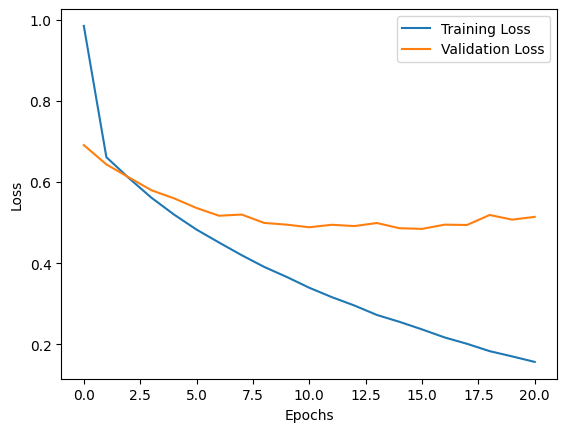

In [ ]:
# Train model
train_size = int(0.9 * train_images.shape[0])
X_train, X_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_labels_onehot[:train_size], train_labels_onehot[train_size:]

weights, train_losses, val_losses = train_mlp(X_train, y_train, X_val, y_val)

# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 0.8466
Precision: 0.8467, Recall: 0.8466, F1-score: 0.8462
ROC AUC: 0.9712


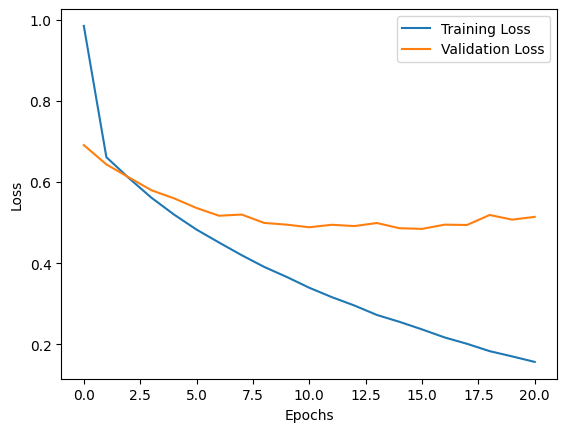

In [ ]:
# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Some hyperparameter trials:

Epoch 1/50 - Train Loss: 1.1841 - Val Loss: 0.7689
Epoch 2/50 - Train Loss: 0.7164 - Val Loss: 0.6915
Epoch 3/50 - Train Loss: 0.6626 - Val Loss: 0.6606
Epoch 4/50 - Train Loss: 0.6280 - Val Loss: 0.6362
Epoch 5/50 - Train Loss: 0.5967 - Val Loss: 0.6130
Epoch 6/50 - Train Loss: 0.5686 - Val Loss: 0.5981
Epoch 7/50 - Train Loss: 0.5432 - Val Loss: 0.5760
Epoch 8/50 - Train Loss: 0.5201 - Val Loss: 0.5596
Epoch 9/50 - Train Loss: 0.4983 - Val Loss: 0.5536
Epoch 10/50 - Train Loss: 0.4798 - Val Loss: 0.5442
Epoch 11/50 - Train Loss: 0.4640 - Val Loss: 0.5340
Epoch 12/50 - Train Loss: 0.4443 - Val Loss: 0.5310
Epoch 13/50 - Train Loss: 0.4299 - Val Loss: 0.5271
Epoch 14/50 - Train Loss: 0.4114 - Val Loss: 0.5206
Epoch 15/50 - Train Loss: 0.3976 - Val Loss: 0.5083
Epoch 16/50 - Train Loss: 0.3831 - Val Loss: 0.5098
Epoch 17/50 - Train Loss: 0.3674 - Val Loss: 0.5103
Epoch 18/50 - Train Loss: 0.3528 - Val Loss: 0.5195
Epoch 19/50 - Train Loss: 0.3378 - Val Loss: 0.4940
Epoch 20/50 - Train L

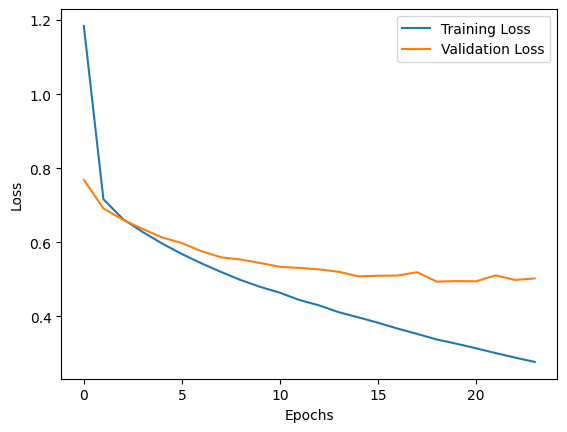

In [ ]:
# Train model
train_size = int(0.9 * train_images.shape[0])
X_train, X_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_labels_onehot[:train_size], train_labels_onehot[train_size:]

weights, train_losses, val_losses = train_mlp(X_train, y_train, X_val, y_val, learning_rate=0.005,)

# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 1.2019 - Val Loss: 0.8030
Epoch 2/50 - Train Loss: 0.7359 - Val Loss: 0.6949
Epoch 3/50 - Train Loss: 0.6751 - Val Loss: 0.6739
Epoch 4/50 - Train Loss: 0.6452 - Val Loss: 0.6538
Epoch 5/50 - Train Loss: 0.6221 - Val Loss: 0.6410
Epoch 6/50 - Train Loss: 0.6011 - Val Loss: 0.6272
Epoch 7/50 - Train Loss: 0.5799 - Val Loss: 0.6175
Epoch 8/50 - Train Loss: 0.5596 - Val Loss: 0.6005
Epoch 9/50 - Train Loss: 0.5395 - Val Loss: 0.5830
Epoch 10/50 - Train Loss: 0.5198 - Val Loss: 0.5763
Epoch 11/50 - Train Loss: 0.5022 - Val Loss: 0.5639
Epoch 12/50 - Train Loss: 0.4857 - Val Loss: 0.5524
Epoch 13/50 - Train Loss: 0.4702 - Val Loss: 0.5455
Epoch 14/50 - Train Loss: 0.4563 - Val Loss: 0.5440
Epoch 15/50 - Train Loss: 0.4413 - Val Loss: 0.5369
Epoch 16/50 - Train Loss: 0.4279 - Val Loss: 0.5371
Epoch 17/50 - Train Loss: 0.4152 - Val Loss: 0.5315
Epoch 18/50 - Train Loss: 0.4017 - Val Loss: 0.5254
Epoch 19/50 - Train Loss: 0.3897 - Val Loss: 0.5316
Epoch 20/50 - Train L

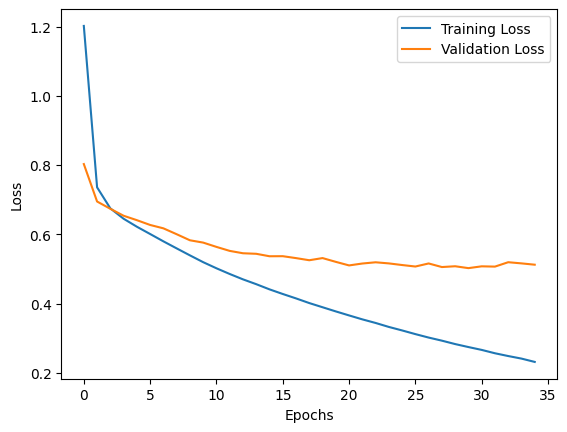

In [ ]:

# Train model
train_size = int(0.9 * train_images.shape[0])
X_train, X_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_labels_onehot[:train_size], train_labels_onehot[train_size:]

weights, train_losses, val_losses = train_mlp(X_train, y_train, X_val, y_val, learning_rate=0.001, batch_size=16,)

# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 0.9558 - Val Loss: 0.6837
Epoch 2/50 - Train Loss: 0.6550 - Val Loss: 0.6409
Epoch 3/50 - Train Loss: 0.5954 - Val Loss: 0.6006
Epoch 4/50 - Train Loss: 0.5406 - Val Loss: 0.5665
Epoch 5/50 - Train Loss: 0.4987 - Val Loss: 0.5341
Epoch 6/50 - Train Loss: 0.4606 - Val Loss: 0.5217
Epoch 7/50 - Train Loss: 0.4276 - Val Loss: 0.5191
Epoch 8/50 - Train Loss: 0.3962 - Val Loss: 0.5055
Epoch 9/50 - Train Loss: 0.3648 - Val Loss: 0.4892
Epoch 10/50 - Train Loss: 0.3381 - Val Loss: 0.4811
Epoch 11/50 - Train Loss: 0.3126 - Val Loss: 0.4840
Epoch 12/50 - Train Loss: 0.2888 - Val Loss: 0.4847
Epoch 13/50 - Train Loss: 0.2667 - Val Loss: 0.4737
Epoch 14/50 - Train Loss: 0.2458 - Val Loss: 0.5043
Epoch 15/50 - Train Loss: 0.2267 - Val Loss: 0.4774
Epoch 16/50 - Train Loss: 0.2063 - Val Loss: 0.4855
Epoch 17/50 - Train Loss: 0.1870 - Val Loss: 0.4920
Epoch 18/50 - Train Loss: 0.1717 - Val Loss: 0.5002
Early stopping triggered at epoch 18.
Test Accuracy: 0.8526
Precision: 0.

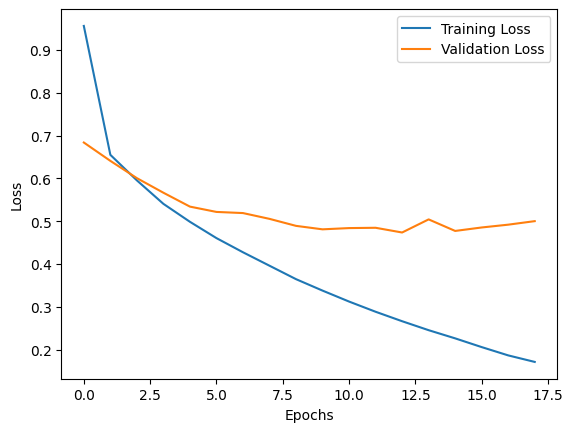

In [ ]:
# Train model
train_size = int(0.9 * train_images.shape[0])
X_train, X_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_labels_onehot[:train_size], train_labels_onehot[train_size:]

weights, train_losses, val_losses = train_mlp(X_train, y_train, X_val, y_val, hidden_dim=256,)

# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 1.0719 - Val Loss: 0.7404
Epoch 2/50 - Train Loss: 0.7016 - Val Loss: 0.6924
Epoch 3/50 - Train Loss: 0.6568 - Val Loss: 0.6583
Epoch 4/50 - Train Loss: 0.6223 - Val Loss: 0.6342
Epoch 5/50 - Train Loss: 0.5924 - Val Loss: 0.6088
Epoch 6/50 - Train Loss: 0.5608 - Val Loss: 0.5878
Epoch 7/50 - Train Loss: 0.5327 - Val Loss: 0.5683
Epoch 8/50 - Train Loss: 0.5067 - Val Loss: 0.5573
Epoch 9/50 - Train Loss: 0.4815 - Val Loss: 0.5349
Epoch 10/50 - Train Loss: 0.4615 - Val Loss: 0.5273
Epoch 11/50 - Train Loss: 0.4376 - Val Loss: 0.5184
Epoch 12/50 - Train Loss: 0.4178 - Val Loss: 0.5087
Epoch 13/50 - Train Loss: 0.3962 - Val Loss: 0.5032
Epoch 14/50 - Train Loss: 0.3777 - Val Loss: 0.4979
Epoch 15/50 - Train Loss: 0.3606 - Val Loss: 0.4920
Epoch 16/50 - Train Loss: 0.3451 - Val Loss: 0.4919
Epoch 17/50 - Train Loss: 0.3264 - Val Loss: 0.4777
Epoch 18/50 - Train Loss: 0.3085 - Val Loss: 0.4824
Epoch 19/50 - Train Loss: 0.2943 - Val Loss: 0.4840
Epoch 20/50 - Train L

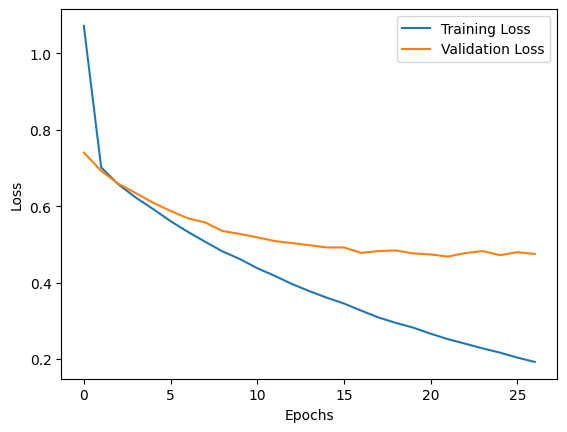

In [ ]:
# Train model
train_size = int(0.9 * train_images.shape[0])
X_train, X_val = train_images[:train_size], train_images[train_size:]
y_train, y_val = train_labels_onehot[:train_size], train_labels_onehot[train_size:]

weights, train_losses, val_losses = train_mlp(X_train, y_train, X_val, y_val, hidden_dim=512, learning_rate=0.005,)

# Evaluate on test set
evaluate_model(test_images, test_labels_onehot, weights)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part 1.2: Implementation with Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

In [ ]:
# Load dataset
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

# Normalize and flatten images
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
# Split training into training and validation
train_size = int(0.9 * len(train_images_tensor))
val_size = len(train_images_tensor) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    TensorDataset(train_images_tensor, train_labels_tensor), [train_size, val_size]
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(test_images_tensor, test_labels_tensor), batch_size=64, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, output_dim=5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

        # Custom weight initialization to match Step 1
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

In [ ]:
# Initialize model, loss, and optimizer
model = MLP(hidden_dim=256)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    train_losses, val_losses, val_aucs = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state_dict = None

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation evaluation
        model.eval()
        val_loss = 0
        all_probs = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_probs.append(outputs.detach().numpy())
                all_labels.append(labels.numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ROC AUC computation
        all_probs = np.vstack(all_probs)
        all_labels = np.concatenate(all_labels)
        all_labels_onehot = np.eye(5)[all_labels]
        val_auc = roc_auc_score(all_labels_onehot, all_probs, multi_class='ovr')
        val_aucs.append(val_auc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val ROC AUC: {val_auc:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    if best_state_dict is not None:
        print("Restoring best model weights.")
        model.load_state_dict(best_state_dict)

    return train_losses, val_losses, val_aucs

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            predictions.extend(preds.numpy())
            true_labels.extend(labels.numpy())
            all_probs.append(outputs.numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    all_probs = np.vstack(all_probs)
    onehot_labels = np.eye(5)[true_labels]

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    roc_auc = roc_auc_score(onehot_labels, all_probs, multi_class='ovr')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return accuracy, precision, recall, f1, roc_auc

In [ ]:
def compare_gradients(model, criterion, optimizer, train_loader):
    # Get first batch
    X_batch, y_batch = next(iter(train_loader))
    X_np = X_batch.numpy()
    y_np = y_batch.numpy()
    y_onehot = np.eye(5)[y_np]

    # 1. From-scratch forward and backward
    scratch_weights = initialize_weights(784, 256, 5)
    A2, cache = forward_pass(X_np, scratch_weights)
    _ = cross_entropy_loss(y_onehot, A2)
    scratch_weights, scratch_velocity = backpropagate(
        X_np, y_onehot, scratch_weights, cache,
        learning_rate=0.01, momentum=0.0
    )
    dW1_scratch = scratch_velocity["dW1"] / -0.01  # Remove learning rate factor

    # 2. Set PyTorch model weights to match scratch
    with torch.no_grad():
        model.fc1.weight.copy_(torch.tensor(scratch_weights["W1"].T))
        model.fc1.bias.copy_(torch.tensor(scratch_weights["b1"].flatten()))
        model.fc2.weight.copy_(torch.tensor(scratch_weights["W2"].T))
        model.fc2.bias.copy_(torch.tensor(scratch_weights["b2"].flatten()))

    # 3. PyTorch forward and backward
    model.train()
    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    grad_torch = model.fc1.weight.grad.detach().numpy().T

    # 4. Compare gradients
    diff = np.abs(dW1_scratch - grad_torch)
    print("Gradient Comparison (W1)")
    print(f"- Mean Absolute Difference: {np.mean(diff):.6e}")
    print(f"- Max Absolute Difference : {np.max(diff):.6e}")


In [ ]:
compare_gradients(model, criterion, optimizer, train_loader)

Gradient Comparison (W1)
- Mean Absolute Difference: 1.547565e-04
- Max Absolute Difference : 4.250599e-03


In [ ]:
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, epochs=150, patience=5)

Epoch 1/150 - Train Loss: 1.5283 - Val Loss: 1.3354 - Val ROC AUC: 0.8774
Epoch 2/150 - Train Loss: 1.2644 - Val Loss: 1.2312 - Val ROC AUC: 0.9074
Epoch 3/150 - Train Loss: 1.2067 - Val Loss: 1.1737 - Val ROC AUC: 0.9225
Epoch 4/150 - Train Loss: 1.1619 - Val Loss: 1.1539 - Val ROC AUC: 0.9273
Epoch 5/150 - Train Loss: 1.1461 - Val Loss: 1.1451 - Val ROC AUC: 0.9285
Epoch 6/150 - Train Loss: 1.1389 - Val Loss: 1.1409 - Val ROC AUC: 0.9286
Epoch 7/150 - Train Loss: 1.1327 - Val Loss: 1.1377 - Val ROC AUC: 0.9298
Epoch 8/150 - Train Loss: 1.1287 - Val Loss: 1.1348 - Val ROC AUC: 0.9311
Epoch 9/150 - Train Loss: 1.1249 - Val Loss: 1.1352 - Val ROC AUC: 0.9307
Epoch 10/150 - Train Loss: 1.1201 - Val Loss: 1.1305 - Val ROC AUC: 0.9317
Epoch 11/150 - Train Loss: 1.1171 - Val Loss: 1.1283 - Val ROC AUC: 0.9320
Epoch 12/150 - Train Loss: 1.1139 - Val Loss: 1.1288 - Val ROC AUC: 0.9320
Epoch 13/150 - Train Loss: 1.1107 - Val Loss: 1.1282 - Val ROC AUC: 0.9339
Epoch 14/150 - Train Loss: 1.1089 

Test Accuracy: 0.8206
Precision: 0.8230, Recall: 0.8206, F1-score: 0.8214
ROC AUC: 0.9556


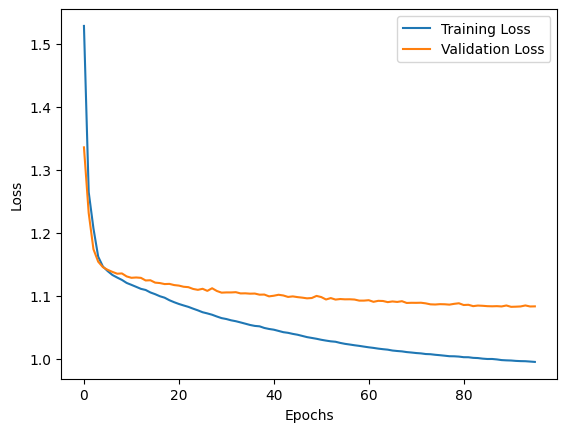

In [ ]:
evaluate_model(model, test_loader)

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model to use it in HW2
torch.save(model.state_dict(), "quickdraw_classifier.pth")

## Part 2.1

In [ ]:
import numpy as np

def load_glove_embeddings(glove_path, target_words):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            tokens = line.strip().split()
            word = tokens[0]
            if word in target_words:
                embeddings[word] = np.array(tokens[1:], dtype=np.float32)
                if len(embeddings) == len(target_words):
                    break
    return embeddings

# Target class labels
class_names = ["rabbit", "yoga", "hand", "snowman", "motorbike"]

# Load GloVe vectors
glove_path = "glove.6B.100d.txt"
glove_vectors = load_glove_embeddings(glove_path, class_names)

# Stack in order
word_embedding_matrix = np.stack([glove_vectors[label] for label in class_names])
print(word_embedding_matrix.shape)  # (5, 100)


(5, 100)


In [ ]:
def cosine_similarity(a, b):
    """Compute cosine similarity between two sets of vectors"""
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
    return np.dot(a_norm, b_norm.T)  # shape (batch_size, num_classes)

def contrastive_loss(z_img, z_words, y_true):
    """
    z_img: (batch_size, D)
    z_words: (num_classes, D)
    y_true: (batch_size,) integer class labels
    """
    sims = cosine_similarity(z_img, z_words)  # (batch_size, 5)
    sims_exp = np.exp(sims)
    probs = sims_exp / np.sum(sims_exp, axis=1, keepdims=True)

    # Cross-entropy
    correct_class_probs = probs[np.arange(len(y_true)), y_true]
    loss = -np.mean(np.log(correct_class_probs + 1e-8))
    return loss


In [ ]:
def relu(x):
    return np.maximum(0, x)

def forward_image_mlp(x, weights):
    z1 = np.dot(x, weights["W1"]) + weights["b1"]
    a1 = relu(z1)
    z2 = np.dot(a1, weights["W2"]) + weights["b2"]
    a2 = relu(z2)
    z3 = np.dot(a2, weights["W3"]) + weights["b3"]
    return z3  # no activation on final layer

def forward_word_mlp(word_vectors, weights):
    z1 = np.dot(word_vectors, weights["W1"]) + weights["b1"]
    a1 = relu(z1)
    z2 = np.dot(a1, weights["W2"]) + weights["b2"]
    return z2  # no activation on final layer


In [ ]:
def init_image_mlp():
    return {
        "W1": np.random.randn(784, 256) * 0.01,
        "b1": np.zeros((1, 256)),
        "W2": np.random.randn(256, 128) * 0.01,
        "b2": np.zeros((1, 128)),
        "W3": np.random.randn(128, 64) * 0.01,
        "b3": np.zeros((1, 64)),
    }

def init_word_mlp():
    return {
        "W1": np.random.randn(100, 64) * 0.01,
        "b1": np.zeros((1, 64)),
        "W2": np.random.randn(64, 64) * 0.01,
        "b2": np.zeros((1, 64)),
    }


In [ ]:
def backward_image_mlp(x, z1, a1, z2, a2, z3, dz3, weights, velocity=None, lr=0.01, momentum=0.9):
    if velocity is None:
        velocity = {k: np.zeros_like(v) for k, v in weights.items()}

    dW3 = np.dot(a2.T, dz3)
    db3 = np.sum(dz3, axis=0, keepdims=True)

    da2 = np.dot(dz3, weights["W3"].T)
    dz2 = da2 * (z2 > 0)

    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, weights["W2"].T)
    dz1 = da1 * (z1 > 0)

    dW1 = np.dot(x.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # SGD with momentum
    for name, grad in zip(["W1", "b1", "W2", "b2", "W3", "b3"],
                          [dW1, db1, dW2, db2, dW3, db3]):
        velocity[name] = momentum * velocity[name] - lr * grad
        weights[name] += velocity[name]

    return weights, velocity


In [ ]:
def compute_dz_words(z_img, z_words, y_true):
    """
    z_img: (B, D)
    z_words: (C, D)
    y_true: (B,)
    Returns: dL/dz_words: (C, D)
    """
    B, D = z_img.shape
    C = z_words.shape[0]

    # Normalize
    z_img_norm = z_img / (np.linalg.norm(z_img, axis=1, keepdims=True) + 1e-8)  # (B, D)
    z_words_norm = z_words / (np.linalg.norm(z_words, axis=1, keepdims=True) + 1e-8)  # (C, D)

    # Cosine similarities
    sims = np.dot(z_img_norm, z_words_norm.T)  # (B, C)
    probs = np.exp(sims) / np.sum(np.exp(sims), axis=1, keepdims=True)  # (B, C)

    # Gradient of loss w.r.t. sim scores
    dL_dsims = probs.copy()
    dL_dsims[np.arange(B), y_true] -= 1  # (B, C)

    # Chain rule: dL/dz_words[c] = sum over i of dL/dsims[i, c] * z_img[i]
    dz_words = np.zeros_like(z_words)  # (C, D)
    for c in range(C):
        coeffs = dL_dsims[:, c].reshape(B, 1)  # (B, 1)
        dz_words[c] = np.sum(coeffs * z_img_norm, axis=0)  # (D,)

    return dz_words


In [ ]:
def backward_word_mlp(x_words, z1, a1, z2, dz2, weights, velocity=None, lr=0.01, momentum=0.9):
    if velocity is None:
        velocity = {k: np.zeros_like(v) for k, v in weights.items()}

    dW2 = np.dot(a1.T, dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = np.dot(dz2, weights["W2"].T)
    dz1 = da1 * (z1 > 0)

    dW1 = np.dot(x_words.T, dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)

    for name, grad in zip(["W1", "b1", "W2", "b2"],
                          [dW1, db1, dW2, db2]):
        velocity[name] = momentum * velocity[name] - lr * grad
        weights[name] += velocity[name]

    return weights, velocity


In [ ]:
def train_embedding_models(
    X_train, y_train,
    word_vectors,  # shape (5, 100)
    img_mlp_weights, word_mlp_weights,
    epochs=50, batch_size=64, lr=0.01, momentum=0.9
):
    img_velocity = None
    word_velocity = None
    train_losses = []

    # Cache transformed GloVe → word MLP forward pass
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0

        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            B = x_batch.shape[0]

            # === Forward pass ===

            # Image MLP
            z1_img = x_batch @ img_mlp_weights["W1"] + img_mlp_weights["b1"]
            a1_img = relu(z1_img)
            z2_img = a1_img @ img_mlp_weights["W2"] + img_mlp_weights["b2"]
            a2_img = relu(z2_img)
            z3_img = a2_img @ img_mlp_weights["W3"] + img_mlp_weights["b3"]  # final embedding (B, 64)

            # Word MLP (all 5 class vectors at once)
            z1_word = word_vectors @ word_mlp_weights["W1"] + word_mlp_weights["b1"]
            a1_word = relu(z1_word)
            z2_word = a1_word @ word_mlp_weights["W2"] + word_mlp_weights["b2"]  # (5, 64)

            # === Loss ===
            loss = contrastive_loss(z3_img, z2_word, y_batch)
            epoch_loss += loss

            # === Backward ===

            # ∂L/∂z_img
            z_img_norm = z3_img / (np.linalg.norm(z3_img, axis=1, keepdims=True) + 1e-8)
            z_word_norm = z2_word / (np.linalg.norm(z2_word, axis=1, keepdims=True) + 1e-8)
            sims = np.dot(z_img_norm, z_word_norm.T)
            probs = np.exp(sims) / np.sum(np.exp(sims), axis=1, keepdims=True)
            dL_dsims = probs.copy()
            dL_dsims[np.arange(B), y_batch] -= 1

            dz3_img = dL_dsims @ z_word_norm  # (B, 64)

            # Image MLP backprop
            img_mlp_weights, img_velocity = backward_image_mlp(
                x_batch, z1_img, a1_img, z2_img, a2_img, z3_img,
                dz3_img, img_mlp_weights, img_velocity, lr, momentum
            )

            # Word MLP backprop
            dz2_word = compute_dz_words(z3_img, z2_word, y_batch)
            word_mlp_weights, word_velocity = backward_word_mlp(
                word_vectors, z1_word, a1_word, z2_word, dz2_word,
                word_mlp_weights, word_velocity, lr, momentum
            )

        train_losses.append(epoch_loss / (X_train.shape[0] // batch_size))
        print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f}")

    return img_mlp_weights, word_mlp_weights, train_losses


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def evaluate_embedding_model(X, y_true, word_vectors, img_mlp_weights, word_mlp_weights):
    z1_img = X @ img_mlp_weights["W1"] + img_mlp_weights["b1"]
    a1_img = relu(z1_img)
    z2_img = a1_img @ img_mlp_weights["W2"] + img_mlp_weights["b2"]
    a2_img = relu(z2_img)
    z3_img = a2_img @ img_mlp_weights["W3"] + img_mlp_weights["b3"]

    z1_word = word_vectors @ word_mlp_weights["W1"] + word_mlp_weights["b1"]
    a1_word = relu(z1_word)
    z2_word = a1_word @ word_mlp_weights["W2"] + word_mlp_weights["b2"]

    z3_img_norm = z3_img / (np.linalg.norm(z3_img, axis=1, keepdims=True) + 1e-8)
    z2_word_norm = z2_word / (np.linalg.norm(z2_word, axis=1, keepdims=True) + 1e-8)

    sims = np.dot(z3_img_norm, z2_word_norm.T)
    y_pred = np.argmax(sims, axis=1)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    y_true_onehot = np.eye(5)[y_true]
    roc_auc = roc_auc_score(y_true_onehot, sims, multi_class='ovr')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    return acc, precision, recall, f1, roc_auc

In [ ]:
def train_embedding_models(
    X_train, y_train,
    word_vectors,
    img_mlp_weights, word_mlp_weights,
    epochs=50, batch_size=64, lr=0.01, momentum=0.9
):
    img_velocity = None
    word_velocity = None
    train_losses = []

    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0

        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size].astype(int)
            B = x_batch.shape[0]

            z1_img = x_batch @ img_mlp_weights["W1"] + img_mlp_weights["b1"]
            a1_img = relu(z1_img)
            z2_img = a1_img @ img_mlp_weights["W2"] + img_mlp_weights["b2"]
            a2_img = relu(z2_img)
            z3_img = a2_img @ img_mlp_weights["W3"] + img_mlp_weights["b3"]

            z1_word = word_vectors @ word_mlp_weights["W1"] + word_mlp_weights["b1"]
            a1_word = relu(z1_word)
            z2_word = a1_word @ word_mlp_weights["W2"] + word_mlp_weights["b2"]

            loss = contrastive_loss(z3_img, z2_word, y_batch)
            epoch_loss += loss

            z_img_norm = z3_img / (np.linalg.norm(z3_img, axis=1, keepdims=True) + 1e-8)
            z_word_norm = z2_word / (np.linalg.norm(z2_word, axis=1, keepdims=True) + 1e-8)
            sims = np.dot(z_img_norm, z_word_norm.T)
            probs = np.exp(sims) / np.sum(np.exp(sims), axis=1, keepdims=True)
            dL_dsims = probs.copy()
            dL_dsims[np.arange(B), y_batch] -= 1
            dz3_img = dL_dsims @ z_word_norm

            img_mlp_weights, img_velocity = backward_image_mlp(
                x_batch, z1_img, a1_img, z2_img, a2_img, z3_img,
                dz3_img, img_mlp_weights, img_velocity, lr, momentum
            )

            dz2_word = compute_dz_words(z3_img, z2_word, y_batch)
            word_mlp_weights, word_velocity = backward_word_mlp(
                word_vectors, z1_word, a1_word, z2_word, dz2_word,
                word_mlp_weights, word_velocity, lr, momentum
            )

        train_losses.append(epoch_loss / (X_train.shape[0] // batch_size))
        print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f}")

    return img_mlp_weights, word_mlp_weights, train_losses

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_accuracies):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='Training Loss', color='tab:blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(val_accuracies, label='Validation Accuracy', color='tab:orange')
    ax2.set_ylabel('Accuracy', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title('Training Loss and Validation Accuracy')
    fig.tight_layout()
    plt.show()


In [ ]:
y_train = np.argmax(train_labels_onehot, axis=1)
y_test = np.argmax(test_labels_onehot, axis=1)

In [ ]:
img_mlp_weights = init_image_mlp()
word_mlp_weights = init_word_mlp()


In [ ]:
img_mlp_weights, word_mlp_weights, train_losses = train_embedding_models(
    train_images, y_train,
    word_embedding_matrix,
    img_mlp_weights, word_mlp_weights,
    epochs=50,
    batch_size=64,
    lr=0.01,
    momentum=0.9
)


Epoch 1 - Loss: 1.6152
Epoch 2 - Loss: 1.6146
Epoch 3 - Loss: 1.6146
Epoch 4 - Loss: 1.6146
Epoch 5 - Loss: 1.6146
Epoch 6 - Loss: 1.6146
Epoch 7 - Loss: 1.6146
Epoch 8 - Loss: 1.6146
Epoch 9 - Loss: 1.6146
Epoch 10 - Loss: 1.6146
Epoch 11 - Loss: 1.6146
Epoch 12 - Loss: 1.6146
Epoch 13 - Loss: 1.6146
Epoch 14 - Loss: 1.6146
Epoch 15 - Loss: 1.6146
Epoch 16 - Loss: 1.6146
Epoch 17 - Loss: 1.6146
Epoch 18 - Loss: 1.6146
Epoch 19 - Loss: 1.6146
Epoch 20 - Loss: 1.6146
Epoch 21 - Loss: 1.6146
Epoch 22 - Loss: 1.6146
Epoch 23 - Loss: 1.6146
Epoch 24 - Loss: 1.6146
Epoch 25 - Loss: 1.6146
Epoch 26 - Loss: 1.6146
Epoch 27 - Loss: 1.6146
Epoch 28 - Loss: 1.6146
Epoch 29 - Loss: 1.6146
Epoch 30 - Loss: 1.6146
Epoch 31 - Loss: 1.6146
Epoch 32 - Loss: 1.6146
Epoch 33 - Loss: 1.6146
Epoch 34 - Loss: 1.6146
Epoch 35 - Loss: 1.6146
Epoch 36 - Loss: 1.6146
Epoch 37 - Loss: 1.6146
Epoch 38 - Loss: 1.6146
Epoch 39 - Loss: 1.6146
Epoch 40 - Loss: 1.6146
Epoch 41 - Loss: 1.6146
Epoch 42 - Loss: 1.6146
E

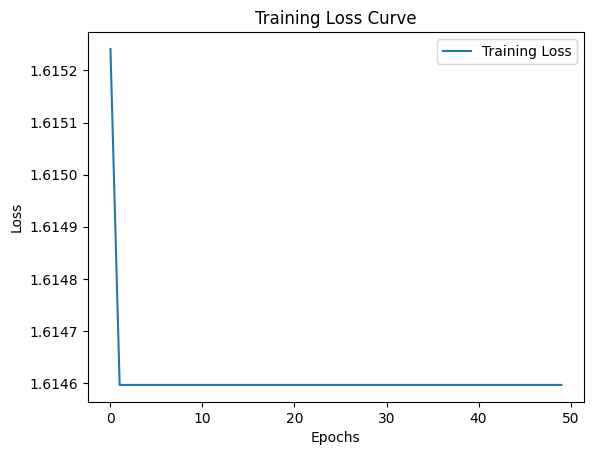

Accuracy: 0.2000
Precision: 0.0400, Recall: 0.2000, F1-score: 0.0667
ROC AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.2, 0.04, 0.2, 0.06666666666666667, np.float64(0.5))

In [ ]:
# Plotting
def plot_loss(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

# Plot training loss
plot_loss(train_losses)

# Final test evaluation
evaluate_embedding_model(test_images, y_test, word_embedding_matrix, img_mlp_weights, word_mlp_weights)

## Part 2.2

Epoch 1: Train Loss = 0.1284, Val Loss = 0.1051
Epoch 2: Train Loss = 0.0919, Val Loss = 0.0889
Epoch 3: Train Loss = 0.0778, Val Loss = 0.0882
Epoch 4: Train Loss = 0.0661, Val Loss = 0.0852
Epoch 5: Train Loss = 0.0579, Val Loss = 0.0861
Epoch 6: Train Loss = 0.0508, Val Loss = 0.0856
Epoch 7: Train Loss = 0.0433, Val Loss = 0.0805
Epoch 8: Train Loss = 0.0366, Val Loss = 0.0793
Epoch 9: Train Loss = 0.0323, Val Loss = 0.0854
Epoch 10: Train Loss = 0.0283, Val Loss = 0.0866
Epoch 11: Train Loss = 0.0245, Val Loss = 0.0902
Epoch 12: Train Loss = 0.0216, Val Loss = 0.0877
Epoch 13: Train Loss = 0.0182, Val Loss = 0.0931
Early stopping triggered at epoch 13.
Restoring best model weights.


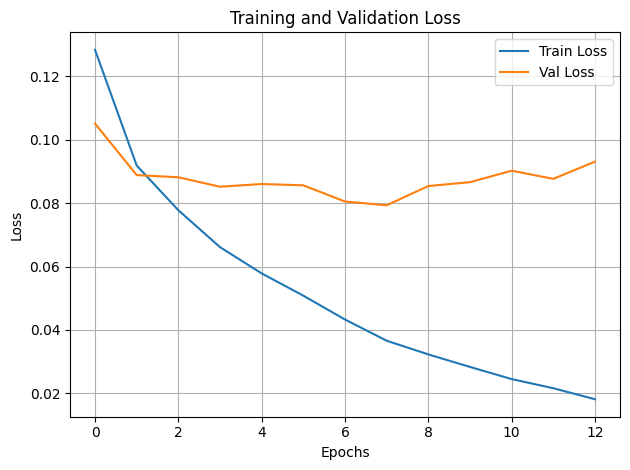

Test Accuracy: 0.8410, Precision: 0.8463, Recall: 0.8410, F1: 0.8417, AUC: 0.9500


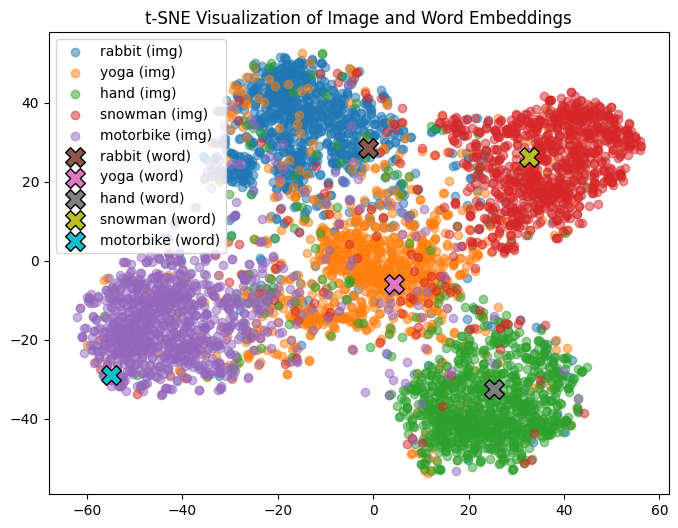

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Word Embedding Loader
def load_glove_embeddings(glove_path, class_names):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            tokens = line.strip().split()
            word = tokens[0]
            if word in class_names:
                embeddings[word] = np.array(tokens[1:], dtype=np.float32)
                if len(embeddings) == len(class_names):
                    break
    return np.stack([embeddings[c] for c in class_names])  # shape (5, 100) as I use 100d

# --- Model Definitions
class ImageMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
    def forward(self, x):
        return self.net(x)

class WordMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
    def forward(self, w):
        return self.net(w)

# --- Contrastive loss function using cross entropy. log-softmax over similarities
def contrastive_loss(z_img, z_words, labels):
    z_img = F.normalize(z_img, dim=1)  # batch of image embeddings (B, D)
    z_words = F.normalize(z_words, dim=1)  # 5 class word embeddings (5, D)
    sims = torch.matmul(z_img, z_words.T)  # similarity scores between every image and every class (Batchsize, 5)
    return F.cross_entropy(sims, labels)

# --- Triplet Loss
def triplet_loss(z_img, z_words, labels, margin=0.2):
    z_img = F.normalize(z_img, dim=1)  # (B, D)
    z_words = F.normalize(z_words, dim=1)  # (5, D)

    anchors = z_img  # (B, D)
    positives = z_words[labels]  # (B, D)

    # Create all negatives for each sample (excluding the positive class)
    batch_size = z_img.size(0)
    all_indices = torch.arange(z_words.size(0), device=z_img.device).expand(batch_size, -1)  # (B, C)
    mask = all_indices != labels.unsqueeze(1)  # (B, C)
    negatives = z_words.unsqueeze(0).expand(batch_size, -1, -1)[mask].view(batch_size, -1, z_words.size(1))  # (B, C-1, D)

    pos_dist = F.pairwise_distance(anchors, positives, p=2)  # (B,)
    neg_dists = torch.norm(anchors.unsqueeze(1) - negatives, dim=2)  # (B, C-1)

    hardest_neg_dist, _ = neg_dists.min(dim=1)  # (B,)

    loss = F.relu(pos_dist - hardest_neg_dist + margin).mean()
    return loss

# --- Training and Evaluation
def train(model_img, model_word, loader, word_embed_tensor, optimizer, device):
    model_img.train()
    model_word.train()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        z_img = model_img(x)
        z_word = model_word(word_embed_tensor)
        loss = triplet_loss(z_img, z_word, y)  # contrastive_loss(z_img, z_word, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# --- Plots
def plot_loss_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss', color='tab:blue')
    plt.plot(val_losses, label='Val Loss', color='tab:orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Training and Evaluation Update
def evaluate_loss(model_img, model_word, loader, word_embed_tensor, device, use_triplet=False):
    model_img.eval()
    model_word.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            z_img = model_img(x)
            z_word = model_word(word_embed_tensor)
            if use_triplet:
                loss = triplet_loss(z_img, z_word, y)
            else:
                loss = contrastive_loss(z_img, z_word, y)
            losses.append(loss.item())
    return np.mean(losses)

# --- TSNE visualization
def visualize_embeddings(model_img, model_word, loader, word_embed_tensor, device, class_names):
    model_img.eval()
    model_word.eval()
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = F.normalize(model_img(x), dim=1).cpu().numpy()
            all_embeddings.append(emb)
            all_labels.extend(y.numpy())
    img_emb = np.concatenate(all_embeddings, axis=0)
    img_labels = np.array(all_labels)

    word_emb = F.normalize(model_word(word_embed_tensor), dim=1).detach().cpu().numpy()

    combined = np.vstack([img_emb, word_emb])
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 6))
    img_reduced = reduced[:img_emb.shape[0]]
    word_reduced = reduced[img_emb.shape[0]:]

    for i in range(5):
        idx = (img_labels == i)
        plt.scatter(img_reduced[idx, 0], img_reduced[idx, 1], label=f"{class_names[i]} (img)", alpha=0.5)

    for i in range(5):
        plt.scatter(word_reduced[i, 0], word_reduced[i, 1], marker='X', s=200, edgecolor='black', label=f"{class_names[i]} (word)")

    plt.legend()
    plt.title("t-SNE Visualization of Image and Word Embeddings")
    plt.show()

# --- Main script ---
if __name__ == "__main__":
    # Load data
    train_images = np.load('train_images.npy')
    train_labels = np.load('train_labels.npy')
    test_images = np.load('test_images.npy')
    test_labels = np.load('test_labels.npy')

    train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
    test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

    # Split validation from train set
    X_train, X_val, y_train, y_val = train_test_split(
        train_images, train_labels, test_size=0.1, stratify=train_labels, random_state=42)

    train_tensor = torch.tensor(X_train, dtype=torch.float32)
    val_tensor = torch.tensor(X_val, dtype=torch.float32)
    test_tensor = torch.tensor(test_images, dtype=torch.float32)
    train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
    val_labels_tensor = torch.tensor(y_val, dtype=torch.long)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(train_tensor, train_labels_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_tensor, val_labels_tensor), batch_size=64, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_tensor, test_labels_tensor), batch_size=64, shuffle=False)

    # Load GloVe embeddings
    class_names = ["rabbit", "yoga", "hand", "snowman", "motorbike"]
    glove_matrix = load_glove_embeddings("glove.6B.100d.txt", class_names)
    word_embed_tensor = torch.tensor(glove_matrix, dtype=torch.float32)

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    word_embed_tensor = word_embed_tensor.to(device)

    # Models and optimizer
    model_img = ImageMLP().to(device)
    model_word = WordMLP().to(device)
    optimizer = optim.SGD(list(model_img.parameters()) + list(model_word.parameters()), lr=0.01, momentum=0.9)

    # Train
    train_losses = []
    val_losses = []
    use_triplet = True
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    best_model_state = {
        'model_img': None,
        'model_word': None,
        'optimizer': None
    }

    for epoch in range(1, 51):
        loss = train(model_img, model_word, train_loader, word_embed_tensor, optimizer, device)
        val_loss = evaluate_loss(model_img, model_word, val_loader, word_embed_tensor, device, use_triplet=use_triplet)
        train_losses.append(loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch}: Train Loss = {loss:.4f}, Val Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model state
            best_model_state['model_img'] = model_img.state_dict()
            best_model_state['model_word'] = model_word.state_dict()
            best_model_state['optimizer'] = optimizer.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

    # Restore best model state
    print("Restoring best model weights.")
    model_img.load_state_dict(best_model_state['model_img'])
    model_word.load_state_dict(best_model_state['model_word'])
    optimizer.load_state_dict(best_model_state['optimizer'])

    plot_loss_curves(train_losses, val_losses)

    # Evaluate on test
    acc, prec, rec, f1, auc = evaluate(model_img, model_word, test_loader, word_embed_tensor, device)
    print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualize
    visualize_embeddings(model_img, model_word, test_loader, word_embed_tensor, device, class_names)
